[0.038, -0.018, 0.265, -0.486]
0.04204759208325728 25.34617594194669
[0.04204759208325728, 0.5535530688199641, 0.6292195574542083]
compare initial conditions
[0.038, -0.018, 0.265, -0.48599999999999993]


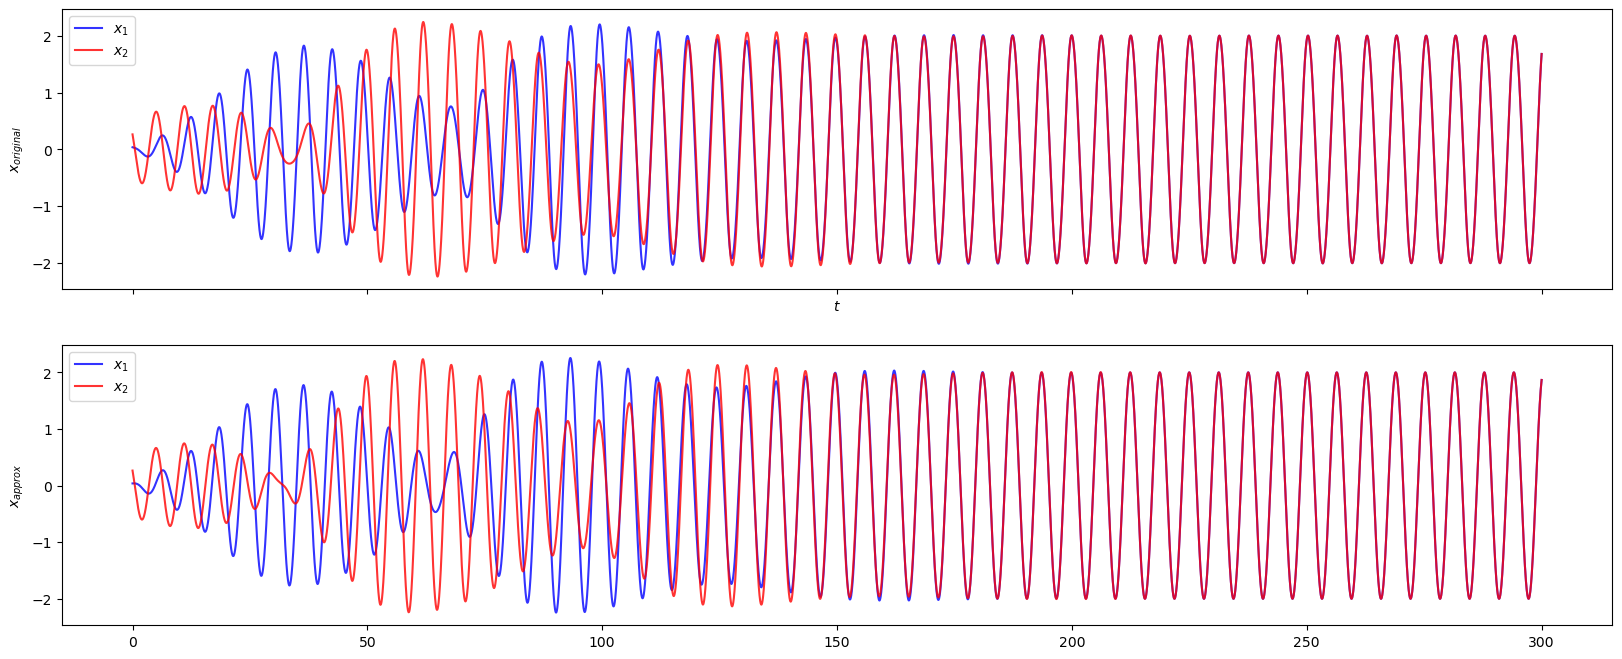

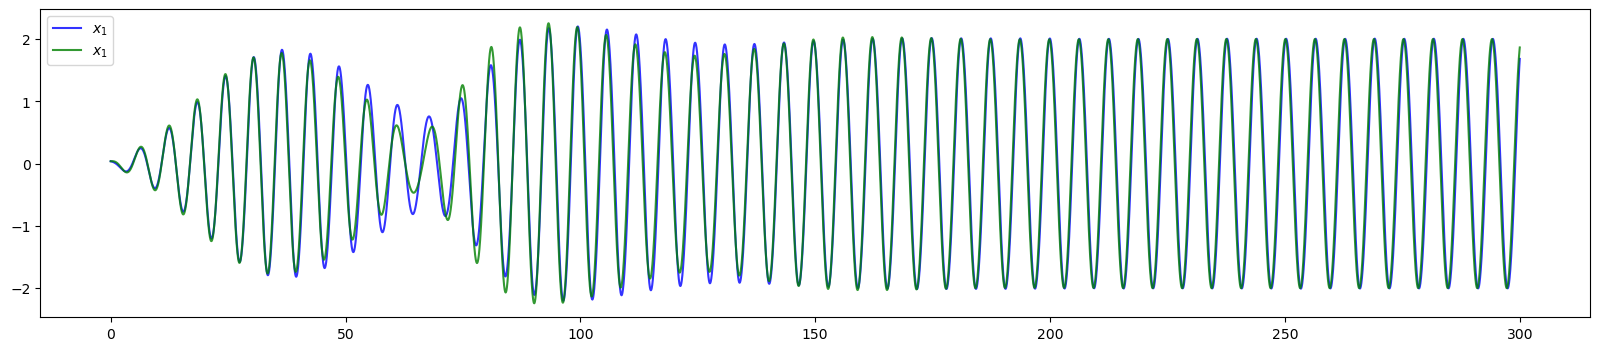

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from scipy.integrate import solve_ivp
import os

# y = dx/dt
# random initial conditions between -0.5 and 0.5, [x1_0, y1_0, x2_0, y2_0]
#x0 = ((np.random.rand(1, 4)[0])-0.5)
x0 = [0.038, -0.018, 0.265, -0.486]#[0.04, 0.02, 0.3, -0.5]#
print(x0)

# Converting to initial conditions to polar coordinates for slow flow
z1 = x0[0] - x0[1]*1j
print(np.abs(z1), np.rad2deg(np.angle(z1)))

z2 = x0[2] - x0[3]*1j

r0 = [np.abs(z1), np.abs(z2), np.angle(z2)-np.angle(z1)]
print(r0)

# [r1_0, r2_0, phi1_0, phi2_0]
r_phi0 = [np.abs(z1), np.abs(z2), np.angle(z1), np.angle(z2)]

print("compare initial conditions")
print(f"[{r_phi0[0]*np.cos(r_phi0[2])}, {-r_phi0[0]*np.sin(r_phi0[2])}, {r_phi0[1]*np.cos(r_phi0[3])}, {-r_phi0[1]*np.sin(r_phi0[3])}]")



EPSILON = 0.1
KAPPA = 1

t_start = 0
t_stop = 300
DURATION = t_stop
SAMPLE_RATE = 1000
SAMPLES = int(DURATION*SAMPLE_RATE)
t = np.linspace(t_start, t_stop, SAMPLE_RATE*DURATION)

# numerical integration of original system
def coupled_vdp_deriv(t, X, eps, k):
    x1, y1, x2, y2 = X
    return [y1, -eps*(x1*x1 - 1)*y1 - x1 + eps*k*(x2 - x1), y2, -eps*(x2*x2 - 1)*y2 - x2 + eps*k*(x1 - x2)]


sol = solve_ivp(coupled_vdp_deriv,
                        [t_start, t_stop],
                        x0,
                        args=[EPSILON, KAPPA],
                        method="LSODA",
                        dense_output=True,
                        t_eval=t)
x1_ori, y1_ori, x2_ori, y2_ori = sol.y


# numerical integration of averaged system
def coupled_r_phi(t, R, eps, k):
    r1, r2, phi1, phi2 = R
    return [  eps/8*r1*(4-r1**2) + eps*k*r2/2*np.sin(phi2-phi1), eps/8*r2*(4-r2**2) - eps*k*r1/2*np.sin(phi2-phi1), eps*k/2*(1 - r2/r1*np.cos(phi2 - phi1)), eps*k/2*(1 - r1/r2*np.cos(phi2 - phi1))  ]

sol = solve_ivp(coupled_r_phi,
                        [t_start, t_stop],
                        r_phi0,
                        args=[EPSILON, KAPPA],
                        method="LSODA",
                        dense_output=True,
                        t_eval=t)
r1, r2, phi1, phi2 = sol.y

# reconstructing the 'fast flow' variable
x1_av  = r1*np.cos(t + phi1)
x2_av = r2*np.cos(t + phi2)


# visualising the data side by side
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 8)) #smaller figsize=(15, 6) #larger figsize=(20, 8)
#axes[0].set_ylim(-0.3, 10)
axes[0].set_ylabel("$x_{original}$")
axes[0].set_xlabel("$t$")
axes[0].plot(t, x1_ori, label="$x_1$", color="blue", alpha=0.8)
axes[0].plot(t, x2_ori, label="$x_2$", color="red", alpha=0.8)
axes[0].legend()

axes[1].set_ylabel("$x_{approx}$")
axes[1].plot(t, x1_av, label="$x_1$", color="blue", alpha=0.8)
axes[1].plot(t, x2_av, label="$x_2$", color="red", alpha=0.8)
axes[1].legend()

dirpath="figs/coupled_comparison"
#fig.suptitle(f"$X_0$=[{x0[0]:.3f}, {x0[1]:.3f}, {x0[2]:.3f}, {x0[3]:.3f}]  $k$={KAPPA}   $\epsilon$={EPSILON}")
#plt.savefig(os.path.join(dirpath, f"notitle_k={KAPPA}_x0=[{x0[0]:.3f},{x0[1]:.3f},{x0[2]:.3f},{x0[3]:.3f}]_ϵ={EPSILON}.png"), dpi=300, format='png', transparent=False, bbox_inches="tight")
plt.show()


plt.figure(figsize=(20, 4))
plt.plot(t, x1_ori, label="$x_1$", color="blue", alpha=0.8)
plt.plot(t, x1_av, label="$x_1$", color="green", alpha=0.8)

plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(t, x2_ori, label="$x_2$", color="red", alpha=0.8)
plt.plot(t, x2_av, label="$x_2$", color="violet", alpha=0.8)

plt.legend()
plt.show()
